In [1]:
from datasets import load_dataset
from tqdm.notebook import tqdm
from mlx import nn
import mlx.core as mx
from mlx_lm import load
from safetensors.numpy import save_file
import numpy as np
import zarr
from numcodecs import Blosc
import json
import os


# --------------------------------------------------------------------------------
# Función para obtener embeddings y capas de forma robusta
# --------------------------------------------------------------------------------
def get_embedding_and_layers(model):
    """
    Devuelve (embed, layers) para este GPTNeoXModel en MLX LM.
    - model.model: GPTNeoXModel
    - mm.embed_in: Embedding
    - mm.h: secuencia de TransformerBlock (h[0]..h[5])
    """
    mm = model.model  # GPTNeoXModel

    # Embedding de entrada
    if not hasattr(mm, "embed_in"):
        raise AttributeError("Esperaba atributo 'embed_in' en GPTNeoXModel")
    embed = mm.embed_in

    # Capas de Transformer
    if hasattr(mm, "layers"):
        layers = mm.layers
    elif hasattr(mm, "h"):
        layers = mm.h
    else:
        raise AttributeError("No encontré ni 'layers' ni 'h' en GPTNeoXModel")

    return embed, layers


def get_hidden_states(input_ids, layer_idx):
    """
    input_ids: mx.array [B, T] (int32)
    layer_idx: índice de capa (0-based), se aplica hasta esa capa inclusive.
    """
    embed, layers = get_embedding_and_layers(model)

    n_layers = len(layers)
    assert 0 <= layer_idx < n_layers, f"layer_idx={layer_idx} fuera de rango (0..{n_layers-1})"

    h = embed(input_ids)

    # Algunas implementaciones aceptan mask="causal", otras no
    for block in layers[: layer_idx + 1]:
        try:
            h = block(h, mask="causal")
        except TypeError:
            h = block(h)

    return h


def save_state(offset):
    with open(state_path, "w") as f:
        json.dump({"offset": offset}, f)


def load_state():
    if os.path.exists(state_path):
        with open(state_path, "r") as f:
            return json.load(f)
    return {"offset": 0}


# --------------------------------------------------------------------------------
# Modelo Pythia 70M deduped con MLX
# --------------------------------------------------------------------------------
model_name = "EleutherAI/pythia-70m-deduped"
model, tokenizer = load(model_name)

# Asegurar que haya token de padding
if tokenizer.pad_token is None:
    # GPT-NeoX usa normalmente eos como fin de texto; lo reutilizamos como pad
    tokenizer.pad_token = tokenizer.eos_token

pad_token_id = tokenizer.pad_token_id
bos_token_id = tokenizer.bos_token_id or tokenizer.eos_token_id

# --------------------------------------------------------------------------------
# Dataset
# --------------------------------------------------------------------------------
dataset = load_dataset("wikipedia", "20220301.simple")

np.random.seed(42)
indices = np.random.permutation(len(dataset["train"]))

# --------------------------------------------------------------------------------
# Parámetros (adaptados a Pythia-70M)
# --------------------------------------------------------------------------------
layer = 3                # Pythia-70M tiene 6 capas (0..5). 3 ≈ “medio”.
seq_len = 64
batch_size = 128
activation_dim = 512     # hidden size de Pythia-70M :contentReference[oaicite:1]{index=1}

n_tokens_est = 11_000_000
zarr_path = "data/Pythia70M-L3-res-wiki.zarr"
input_ids_path = "data/Pythia70M-L3-res-wiki-token-ids.jsonl"
state_path = zarr_path + ".state.json"

# --------------------------------------------------------------------------------
# Abrir / crear dataset Zarr
# --------------------------------------------------------------------------------
if not os.path.exists(zarr_path):
    print("Creando nuevo dataset...")
    z = zarr.open(
        zarr_path,
        mode="w",
        shape=(n_tokens_est, activation_dim),
        dtype="f2",  # float16
        chunks=(10_000, activation_dim),
        compressor=Blosc(cname="zstd", clevel=5, shuffle=Blosc.SHUFFLE),
        zarr_format=2,
    )
    state = {"offset": 0}
else:
    print("Reanudando dataset...")
    z = zarr.open(zarr_path, mode="r+")
    state = load_state()

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Reanudando dataset...


In [6]:
z.resize((n_tokens_est, activation_dim))

In [2]:
z.shape

(11000000, 512)

In [5]:
state

{'offset': 30098498}

In [6]:
# --------------------------------------------------------------------------------
# Reanudación tipo "dry run": recorrer dataset hasta offset guardado
# --------------------------------------------------------------------------------
target_offset = state["offset"]
target_offset = 10000000

dry_run = True
offset = 0
buffer = []

try:
    with tqdm(indices, total=len(indices)) as pbar:
        for i, idx in enumerate(pbar):
            text = dataset["train"][idx.item()]["text"]
            # Para Pythia no hace falta quitar BOS manualmente; tokenizer no suele anteponerlo.
            tokens = tokenizer.encode(text)

            for j in range(0, len(tokens), seq_len - 1):
                chunk = tokens[j : j + (seq_len - 1)]
                if len(chunk) < (seq_len - 1):
                    chunk = chunk + [pad_token_id] * ((seq_len - 1) - len(chunk))
                # Insertar BOS al inicio
                chunk = [bos_token_id] + chunk
                buffer.append(chunk)

                if len(buffer) >= batch_size:
                    batch = buffer[:batch_size]
                    buffer = buffer[batch_size:]

                    if dry_run:
                        # Solo contamos cuántos tokens válidos serían
                        input_ids = np.array(batch, dtype=np.int32)
                        flat = input_ids.reshape(-1)
                        valid_mask = (flat != pad_token_id) & (flat != bos_token_id)
                        n_valid = int(valid_mask.sum())
                        offset += n_valid

                        if offset >= target_offset:
                            print(f"✅ Dry run terminado en offset={offset}, retomando guardado real")
                            dry_run = False
                            offset = target_offset  # Alinear exacto
                    else:
                        # Procesamos y guardamos
                        input_ids = mx.array(batch, dtype=mx.int32)

                        x = get_hidden_states(input_ids, layer)

                        # Seleccionar solo tokens "reales" (no BOS ni PAD)
                        input_ids_np = np.array(batch, dtype=np.int32).reshape(-1)
                        valid_mask = (input_ids_np != pad_token_id) & (input_ids_np != bos_token_id)
                        valid_indices = np.where(valid_mask)[0]

                        x = x.reshape(-1, activation_dim)
                        x = x[valid_indices.tolist()]

                        arr = np.asarray(x, dtype=np.float16)
                        n = arr.shape[0]

                        z[offset : offset + n, :] = arr
                        offset += n

                        # Guardar también IDs de tokens válidos
                        with open(input_ids_path, "a") as f:
                            for row in batch:
                                valid_tids = [int(t) for t in row if t not in (pad_token_id, bos_token_id)]
                                f.write(json.dumps(valid_tids) + "\n")

            if i % 100 == 0 and not dry_run:
                save_state(offset)

            pbar.set_postfix({"n_tokens": offset})
except KeyboardInterrupt:
    print("\n⚠️ Pausado manualmente. Guardando estado...")
    save_state(offset)

  0%|          | 0/205328 [00:00<?, ?it/s]

✅ Dry run terminado en offset=10006932, retomando guardado real


In [1]:
import matplotlib.pyplot as plt

In [20]:
a = mx.linalg.norm(mx.array(z[:10000]), axis=1)

In [35]:
np.percentile(a, 95)

17.5

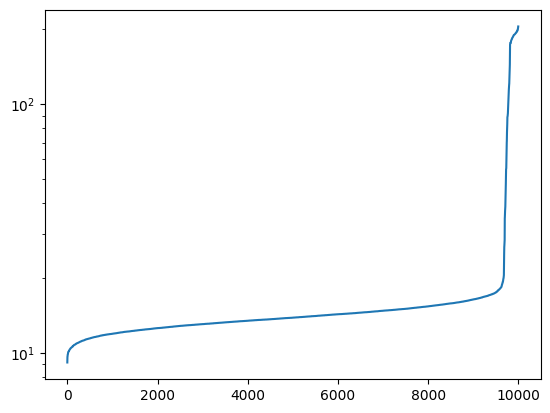

In [24]:
plt.plot(np.sort(a))
plt.yscale('log')

In [1]:
from datasets import load_dataset
from tqdm.notebook import tqdm
from mlx import nn
import mlx.core as mx
from mlx_lm import load
import numpy as np
import zarr
from numcodecs import Blosc
import json
import os

# --------------------------------------------------------------------------------
# Función para obtener embeddings y capas de forma robusta
# --------------------------------------------------------------------------------
def get_embedding_and_layers(model):
    """
    Devuelve (embed, layers) para este GPTNeoXModel en MLX LM.
    - model.model: GPTNeoXModel
    - mm.embed_in: Embedding
    - mm.h o mm.layers: secuencia de TransformerBlock
    """
    mm = model.model  # GPTNeoXModel

    if not hasattr(mm, "embed_in"):
        raise AttributeError("Esperaba atributo 'embed_in' en GPTNeoXModel")
    embed = mm.embed_in

    if hasattr(mm, "layers"):
        layers = mm.layers
    elif hasattr(mm, "h"):
        layers = mm.h
    else:
        raise AttributeError("No encontré ni 'layers' ni 'h' en GPTNeoXModel")

    return embed, layers


def get_hidden_states_two_layers(input_ids, layer_a, layer_b):
    """
    input_ids: mx.array [B, T] (int32)
    layer_a, layer_b: índices 0-based. Devuelve (h_a, h_b) donde h_k es el hidden
    state DESPUÉS de aplicar la capa k.
    Hace un solo forward secuencial.
    """
    embed, layers = get_embedding_and_layers(model)
    n_layers = len(layers)

    assert 0 <= layer_a < n_layers, f"layer_a={layer_a} fuera de rango (0..{n_layers-1})"
    assert 0 <= layer_b < n_layers, f"layer_b={layer_b} fuera de rango (0..{n_layers-1})"

    # Asegurar orden (para recorrer una sola vez)
    a, b = (layer_a, layer_b) if layer_a <= layer_b else (layer_b, layer_a)
    ha = hb = None

    h = embed(input_ids)

    for li, block in enumerate(layers):
        try:
            h = block(h, mask="causal")
        except TypeError:
            h = block(h)

        if li == a:
            ha = h
        if li == b:
            hb = h
            break

    if ha is None or hb is None:
        raise RuntimeError("No se pudieron capturar los hidden states solicitados")

    # Si el usuario pidió (layer_a, layer_b) invertidos, devolvemos en el orden original
    if layer_a <= layer_b:
        return ha, hb
    else:
        return hb, ha


def save_state(offset):
    with open(state_path, "w") as f:
        json.dump({"offset": offset}, f)


def load_state():
    if os.path.exists(state_path):
        with open(state_path, "r") as f:
            return json.load(f)
    return {"offset": 0}


# --------------------------------------------------------------------------------
# Modelo Pythia 70M deduped con MLX
# --------------------------------------------------------------------------------
model_name = "EleutherAI/pythia-70m-deduped"
model, tokenizer = load(model_name)

# Asegurar que haya token de padding
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

pad_token_id = tokenizer.pad_token_id
bos_token_id = tokenizer.bos_token_id or tokenizer.eos_token_id

# --------------------------------------------------------------------------------
# Dataset
# --------------------------------------------------------------------------------
dataset = load_dataset("wikipedia", "20220301.simple")

np.random.seed(42)
indices = np.random.permutation(len(dataset["train"]))

# --------------------------------------------------------------------------------
# Parámetros
# --------------------------------------------------------------------------------
seq_len = 64
batch_size = 128
activation_dim = 512  # hidden size de Pythia-70M

# Capas a guardar:
# - primera capa = layer 0 (salida post layers[0])
# - última capa = layer n_layers-1
_, _layers = get_embedding_and_layers(model)
n_layers = len(_layers)
layer_first = 0
layer_last = n_layers - 1

n_tokens_est = 11_000_000

# Archivos de salida (dos Zarr)
zarr_path_first = "data/Pythia70M-L0-res-wiki.zarr"
zarr_path_last  = f"data/Pythia70M-L{layer_last}-res-wiki.zarr"

input_ids_path = "data/Pythia70M-res-wiki-token-ids.jsonl"

# Estado compartido (un offset para ambos Zarr)
state_path = "data/Pythia70M-L0-Llast-res-wiki.state.json"

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [2]:
# --------------------------------------------------------------------------------
# Abrir / crear datasets Zarr (dos arrays con mismo shape)
# --------------------------------------------------------------------------------
def open_or_create_zarr(path):
    if not os.path.exists(path):
        print(f"Creando nuevo dataset Zarr: {path}")
        return zarr.open(
            path,
            mode="w",
            shape=(n_tokens_est, activation_dim),
            dtype="f2",
            chunks=(10_000, activation_dim),
            compressor=Blosc(cname="zstd", clevel=5, shuffle=Blosc.SHUFFLE),
            zarr_format=2,
        )
    else:
        print(f"Reanudando dataset Zarr: {path}")
        return zarr.open(path, mode="r+")

z_first = open_or_create_zarr(zarr_path_first)
z_last  = open_or_create_zarr(zarr_path_last)

state = load_state()

Creando nuevo dataset Zarr: data/Pythia70M-L0-res-wiki.zarr
Creando nuevo dataset Zarr: data/Pythia70M-L5-res-wiki.zarr


In [3]:
state

{'offset': 0}

In [4]:
# --------------------------------------------------------------------------------
# Reanudación tipo "dry run": recorrer dataset hasta offset guardado
# --------------------------------------------------------------------------------
target_offset = state["offset"]

dry_run = False
offset = 0
buffer = []

try:
    with tqdm(indices, total=len(indices)) as pbar:
        for i, idx in enumerate(pbar):
            text = dataset["train"][idx.item()]["text"]
            tokens = tokenizer.encode(text)

            for j in range(0, len(tokens), seq_len - 1):
                chunk = tokens[j : j + (seq_len - 1)]
                if len(chunk) < (seq_len - 1):
                    chunk = chunk + [pad_token_id] * ((seq_len - 1) - len(chunk))
                chunk = [bos_token_id] + chunk
                buffer.append(chunk)

                if len(buffer) >= batch_size:
                    batch = buffer[:batch_size]
                    buffer = buffer[batch_size:]

                    # Máscara de válidos (una sola vez)
                    input_ids_np = np.array(batch, dtype=np.int32).reshape(-1)
                    valid_mask = (input_ids_np != pad_token_id) & (input_ids_np != bos_token_id)
                    valid_indices = np.where(valid_mask)[0]
                    n_valid = int(valid_mask.sum())

                    if dry_run:
                        offset += n_valid
                        if offset >= target_offset:
                            print(f"✅ Dry run terminado en offset={offset}, retomando guardado real")
                            dry_run = False
                            offset = target_offset  # Alinear exacto
                    else:
                        # Forward MLX (una sola pasada) y capturar L0 y Llast
                        input_ids = mx.array(batch, dtype=mx.int32)
                        x_first, x_last = get_hidden_states_two_layers(input_ids, layer_first, layer_last)

                        # Flatten + filtrar válidos (misma máscara para ambas)
                        x_first = x_first.reshape(-1, activation_dim)[valid_indices.tolist()]
                        x_last  = x_last.reshape(-1, activation_dim)[valid_indices.tolist()]

                        arr_first = np.asarray(x_first, dtype=np.float16)
                        arr_last  = np.asarray(x_last, dtype=np.float16)
                        n = arr_first.shape[0]
                        assert arr_last.shape[0] == n, "Desalineación entre capas"

                        # Guardar en ambos Zarr con el mismo offset
                        z_first[offset : offset + n, :] = arr_first
                        z_last[offset  : offset + n, :] = arr_last
                        offset += n

                        # Guardar también IDs de tokens válidos (una sola vez)
                        with open(input_ids_path, "a") as f:
                            for row in batch:
                                valid_tids = [int(t) for t in row if t not in (pad_token_id, bos_token_id)]
                                f.write(json.dumps(valid_tids) + "\n")

            if i % 100 == 0 and not dry_run:
                save_state(offset)

            pbar.set_postfix({"n_tokens": offset, "dry_run": dry_run})
except KeyboardInterrupt:
    print("\n⚠️ Pausado manualmente. Guardando estado...")
    save_state(offset)

  0%|          | 0/205328 [00:00<?, ?it/s]

In [2]:
import mlx.core as mx
import numpy as np
import zarr
import matplotlib.pyplot as plt

In [13]:
zarr_path = "data/Pythia70M-L0-res-wiki.zarr"
z = zarr.open(zarr_path, mode="r+")
z.shape

(11000000, 512)

In [10]:
# L5
a = mx.linalg.norm(mx.array(z[:10000]), axis=1)
np.percentile(a, 95)

np.float16(105.3)

In [14]:
# L0
a = mx.linalg.norm(mx.array(z[:10000]), axis=1)
np.percentile(a, 95)

np.float16(9.56)

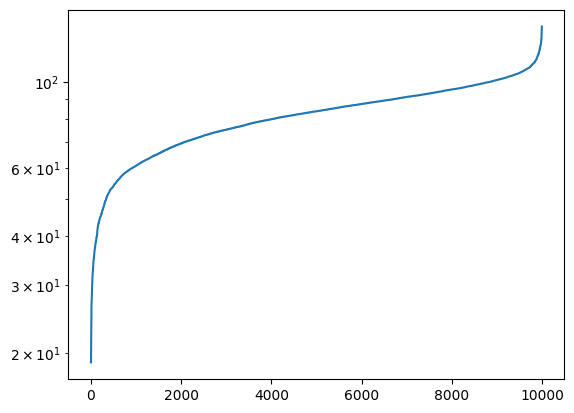

In [11]:
plt.plot(np.sort(a))
plt.yscale('log')